# Deepwalk performance on hetionet alone

read each feature set and test set in linear order

calculate the roc values and save


after all done:
    draw graph

In [33]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

from glob import glob
import os
import seaborn as sns

In [2]:
%matplotlib inline

---

In [3]:
def add_features(df, features):
    return (df
        .merge(
            features, how="inner", left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how="inner", left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize):
    reg = add_features(df, features)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

there are nodes in the holdout dataset that did not have any embeddings generated for it. check to see if they had proper adjlists made

In [4]:
def eval_performance(fbase, K, vecsize):
    for idx in range(K):
        train = pd.read_csv(
            "tmp/data/train/{}_train_{}.tsv".format(fbase, idx),
            sep='\t'
        )
        
        holdout = pd.read_csv(
            "tmp/data/holdout/{}_holdout_{}.tsv".format(fbase, idx),
            sep='\t'
        )

        features = pd.read_csv(
            "tmp/data/embeddings/{}_embedding_{}.txt".format(fbase, idx),
            sep=" ", skiprows=1,
            names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
        )

        tmp = convolv_features(train, features, vecsize)

        feat_cols = ["conv{}".format(j) for j in range(vecsize)]
        regmodel = LogisticRegression(C=1e9).fit(tmp[feat_cols], tmp["etype"])

        # test on holdout
        test = convolv_features(
            holdout.drop("etype", axis=1),
            features, vecsize
        )

        # add in predictions
        ans = test.assign(
            predval = lambda df: regmodel.predict_proba(df[feat_cols])[:, 1]
        )
        
        yield (ans
            [["chemical_uid", "disease_uid", "predval"]]
            .merge(
                holdout[["chemical_uid", "disease_uid", "etype"]],
                how="inner", on=["chemical_uid", "disease_uid"]
            )
            .sort_values("predval", ascending=False)
            .reset_index(drop=True)
        )

In [5]:
def finished(fbase, K):
    for i in range(K):
        ename = "tmp/data/embeddings/{}_embedding_{}.txt".format(fbase, i)
        
        if not os.path.isfile(ename):
            return False

    return True

In [6]:
K = 3
vecsize = 128

for edge_fname in tqdm(glob("tmp/edges/*.tsv")):
    fbase = edge_fname.split("/")[2][:-4]
    
    # check if all 3 embeddings are done
    if finished(fbase, K):

        aucs = []
        for res in eval_performance(fbase, K, vecsize):
            fpr, tpr, thresh = roc_curve(res["etype"], res["predval"])

            auc_val = auc(fpr, tpr)
            aucs.append(auc_val)

        temp = (pd
            .Series(aucs)
            .to_frame("auc_roc")
            .assign(edge_val = fbase)
        )
        
        temp.to_csv(
            "tmp/results/{}.tsv".format(fbase), sep='\t', index=False
        )

100%|██████████| 107/107 [13:57<00:00,  7.83s/it]


---

In [13]:
res = [
    pd.read_csv(fname, sep='\t')
    for fname in glob("tmp/results/*.tsv")
]

res = pd.concat(res)

In [14]:
res.shape

(294, 2)

In [15]:
res.head()

,auc_roc,edge_val
0,0.815303,Disease_Anatomy_0.6_pct_kept
1,0.812408,Disease_Anatomy_0.6_pct_kept
2,0.817970,Disease_Anatomy_0.6_pct_kept
0,0.831167,Gene_Gene_0.1_pct_kept
1,0.831318,Gene_Gene_0.1_pct_kept


In [29]:
data = (res
    .assign(
        pct_kept = lambda df:
            df["edge_val"].str.split("_").str[2].pipe(pd.to_numeric)
    )
    .assign(
        edge_type = lambda df:
            df["edge_val"].str[:-13]
    )
)

In [30]:
data.head()

,auc_roc,edge_val,pct_kept,edge_type
0,0.815303,Disease_Anatomy_0.6_pct_kept,0.6,Disease_Anatomy
1,0.812408,Disease_Anatomy_0.6_pct_kept,0.6,Disease_Anatomy
2,0.817970,Disease_Anatomy_0.6_pct_kept,0.6,Disease_Anatomy
0,0.831167,Gene_Gene_0.1_pct_kept,0.1,Gene_Gene
1,0.831318,Gene_Gene_0.1_pct_kept,0.1,Gene_Gene


In [32]:
data.dtypes

auc_roc      float64
edge_val      object
pct_kept     float64
edge_type     object
dtype: object

In [39]:
avgs = (data
    .groupby(["edge_type", "pct_kept"])
    .mean()
    .reset_index()
)

In [41]:
avgs.shape

(98, 3)

In [42]:
avgs.head()

,edge_type,pct_kept,auc_roc
0,Anatomy_Gene,0.1,0.833497
1,Anatomy_Gene,0.2,0.835753
2,Anatomy_Gene,0.3,0.834169
3,Anatomy_Gene,0.4,0.835438
4,Anatomy_Gene,0.5,0.822208


---

In [ ]:
sns.factorplot(
    data=avgs.query("", x="pct_kept", y="auc_roc", hue="edge_type",
    size=10, aspect=0.8
)

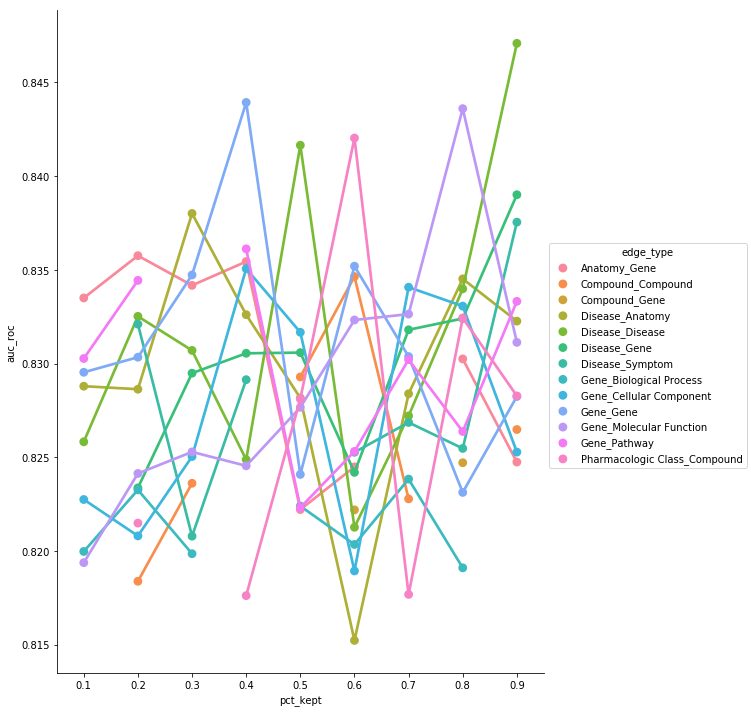

In [44]:
sns.factorplot(
    data=avgs, x="pct_kept", y="auc_roc", hue="edge_type",
    size=10, aspect=0.8
)

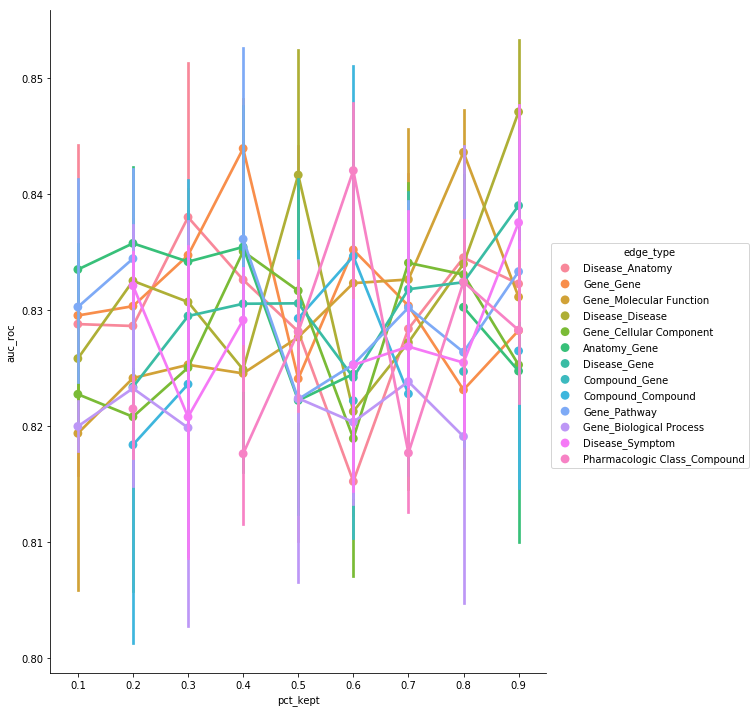

In [46]:
sns.factorplot(
    data=data, x="pct_kept", y="auc_roc", hue="edge_type",
    size=10, aspect=0.8
)